In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 8
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10

'''
x_train, y_train, x_test, y_test, rotation = pickle.load(open('data.pickle', 'rb'))

x_test = x_test[:n_test]
y_test = y_test[:n_test]

'''
#rotation = special_ortho_group.rvs(dim_in)
rotation = np.identity(dim_in)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(1000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)


sample_range = [100, 200, 400, 800, 1600]

M = 20                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

In [2]:
pickle.dump([x_train, y_train, x_test, y_test, rotation], open('axis_aligned_data.pickle', 'wb'))

In [3]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

In [4]:
def plot_trend(stats, x_axis, y_axis, title, xlabel = None, ylabel = None):
    df = pd.DataFrame(stats)

    # Prepare the data for plotting
    plot_data = [df[y_axis][i] for i in range(len(df))]

    # Create the boxplot
    plt.boxplot(plot_data, labels=[str(x[x_axis]) for x in stats])

    # Add titles and labels
    plt.title(title)
    if xlabel is None:
        xlabel = x_axis
    if ylabel is None:
        ylabel = y_axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

# Save training history

In [5]:
lifetime = 4

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train[:n_sim, ], y_train[:n_sim, ], x_test, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:13<00:00, 13.38s/it]


# Get H estimate

In [6]:
def get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H):
    H_est = []
    for i in range(len(sample_range)):
        n_sim = sample_range[i]
        dist = {'n': n_sim, 'mse': [], 'H': []}
        for trial in tqdm(range(tries)):
            y_hat_test, history, X_bd_all, w_trees = \
                stats[i]['history'][trial]
            dist['mse'].append(mean_squared_error(y_test, y_hat_test))
            H_0 = estimate_H_ind(x_train, y_train, X_bd_all, M, x_test, history, w_trees, y_hat_test)
            dist['H'].append(H_0)
        H_est.append(dist)
        
    return H_est

raw_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind)

100%|██████████| 10/10 [05:27<00:00, 32.73s/it]


In [7]:
def operator_norm(H, truth):
    norm_truth = norm(truth, ord = 2)
    return norm(truth - H, ord = 2)/norm_truth

def get_eig(A):
    eigenValues, eigenVectors = linalg.eig(A)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

In [8]:
def plot_dist(H_estimates, title, true_H, norm_H, norm_func):
    plot_data = []
    for i in range(len(sample_range)):
        dist = H_estimates[i]
        n_sim = sample_range[i]
        alter_dist = {'n': n_sim, 'dist':[]}
        for trial in range(tries):
            H_0 = dist['H'][trial]
            alter_dist['dist'].append(norm_func(H_0, true_H))
        plot_data.append(alter_dist)
    try:
        plot_trend(plot_data, 'n', 'dist', title, ylabel='Operator distance from the True H')
    except:
        pass


def plot_H_estimates(raw_H_estimates, true_H, norm_func):

    norm_H = norm(true_H, ord = 2)
    plot_dist(raw_H_estimates, 'Unnormalised', true_H, norm_H, norm_func)

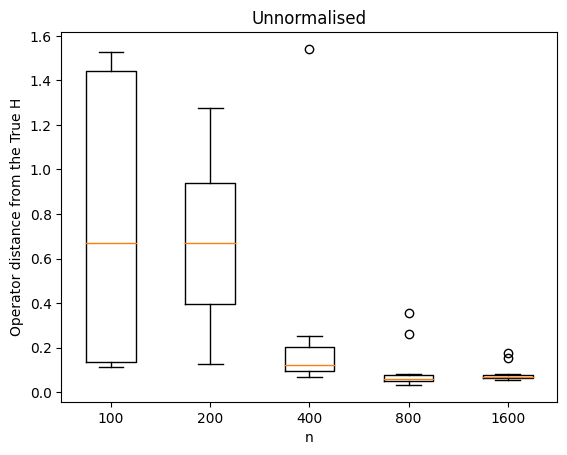

In [9]:
np.set_printoptions(precision=4)
plot_H_estimates(raw_H_estimates, true_H, get_angle_distance)

# Eliza's method for estimating gradients

In [10]:
def estimate_H_ind_(x_train, y_train, X_bd_all, M, X_test, history, delta, y_hat_test):
    dim_in = X_test.shape[1]
    N_test = X_test.shape[0]
    importance = []
    for dim in range(dim_in):
        try:
            x_eval = None
            y_eval = []
            x_diff = []
            subset_all = []
            for tree in range(M):
                temp = X_bd_all[tree,dim] - X_test
                subset = temp[:,dim] != 0
                subset_all = subset_all + list(subset)
                
                if sum(subset) > 0:
                    if x_eval is None:
                        x_eval = X_bd_all[tree,dim][subset]
                    else:
                        x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
                    y_eval = y_eval + y_hat_test[subset].tolist()
                    x_diff = x_diff + list(temp[:,dim][subset])
            
            _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, history, delta)
            y_eval = np.array(y_eval)
            x_diff = np.abs(x_diff)
            y_diff = populate_importance(subset_all, y_eval - y_hat_eval)
            x_diff = populate_importance(subset_all, x_diff)
            y_diff = np.reshape(y_diff, (N_test, M))
            x_diff = np.reshape(x_diff, (N_test, M))
            y_diff = np.mean(y_diff, axis = 1)
            x_diff = np.mean(x_diff, axis = 1)
            y_diff[x_diff == 0] = 0
            x_diff[x_diff == 0] = 1
            importance_temp = y_diff/x_diff
        except:
            importance_temp = np.zeros(N_test)
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))/N_test
    return H

#alter_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind_)

In [12]:
#plot_H_estimates(alter_H_estimates, true_H, get_angle_distance)

In [13]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime_max, delta))

In [ ]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [ ]:
x_train_transformed, x_test_transformed = transform_data(raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0]), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

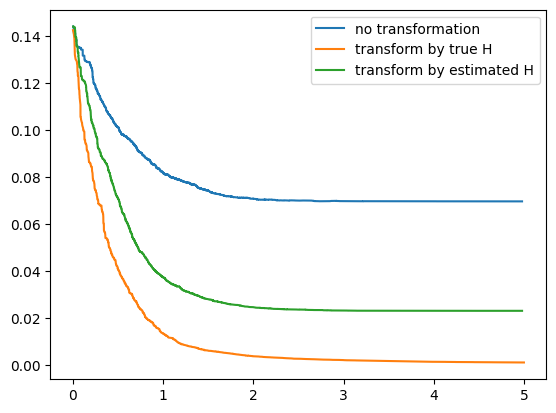

In [ ]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [ ]:
raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

NameError: name 'raw_H_estimates' is not defined